## 编程题

在CIFAR10图像数据集上练习训练深度神经网络：

CIFAR-10数据集，又称加拿大高等研究院数据集（Canadian Institute for Advanced Research）是一个常用于训练机器学习和计算机视觉算法的图像集合。它是最广泛使用的机器学习研究数据集之一。

CIFAR-10数据集包含60,000张32×32像素的彩色图像，分为10个不同的类别。这10个类别分别是飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车，每个类别有6,000张图片。

飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车 对应的分类编码是0，1，2，3，4，5，6，7，8，9


1. 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数。
2. 使用Nadam优化和早停技术，在CIFAR10数据集上训练网络。可以使用tf.keras.datasets.cifar10.load_data()加载数据。该数据集由10个类别的60000幅32×32像素的彩色图像（用于训练的50000个，用于测试的10000个）组成，因此需要一个具有10个神经元的softmax输出层。记住，每次更改模型的架构或超参数时，都要找寻正确的学习率。
3. 尝试添加批量归一化并比较学习曲线：收敛速度是否比以前快？会产生更好的模型吗？它如何影响训练速度？
4. 尝试用SELU替换批量归一化，并进行必要的调整以确保网络是自归一化的（即归一化输入特征，使用LeCun正态初始化，确保DNN仅仅包含一系列的密集层等）
5. 尝试使用Alpha dropout正则化模型。然后，在不重新训练模型的情况下，看看是否可以使用MC dropout获得更好的精度。
6. 使用1周期调度来重新训练模型，看看它是否可以提高训练速度和模型精度。

In [1]:
# 加载数据的代码
import tensorflow as tf
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
# 查看数据集形状
print("训练集图片形状:", X_train_full.shape) # 应该是 (50000, 32, 32, 3)
print("训练集标签形状:", y_train_full.shape) # 应该是 (50000, 1)

训练集图片形状: (50000, 32, 32, 3)
训练集标签形状: (50000, 1)


In [2]:
# 按0-9顺序定义类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

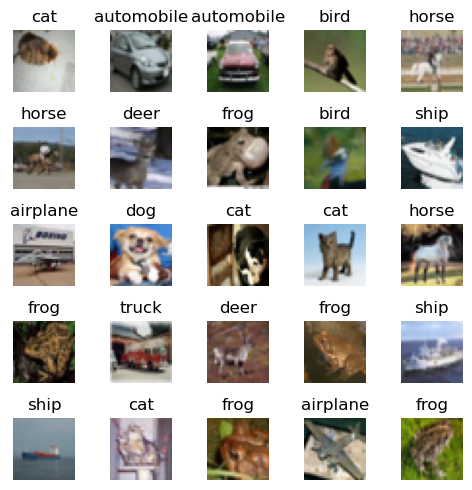

In [3]:
import numpy as np
import matplotlib.pyplot as plt

nrows = 5
ncols = 5

plt.figure(figsize=(5, 5))


random_indices = np.random.choice(len(X_train_full), nrows * ncols, replace=False)  # 无放回随机抽索引

for i, idx in enumerate(random_indices):
    plt.subplot(nrows, ncols, i+1)
    img = X_train_full[idx]
    label = y_train_full[idx, 0]
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

# 调整子图之间的间距，防止标题等重叠
plt.tight_layout()
plt.show()

In [4]:
# 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数。

model = tf.keras.models.Sequential([])
model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 activation="swish",
                                 kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

C:\Users\31752\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

In [6]:
import os
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_weights.weights.h5",save_best_only=True, save_weights_only=True)
run_index = 1 # 每训练一次 run_index+=1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_{run_index:03d}")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [7]:
# tensorboard --logdir=./logs/my_cifar10_logs --port=6006

In [8]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1487 - loss: 7.6594 - val_accuracy: 0.1944 - val_loss: 2.2280
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2241 - loss: 2.1238 - val_accuracy: 0.2172 - val_loss: 2.1079
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2690 - loss: 1.9968 - val_accuracy: 0.2768 - val_loss: 1.9934
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2995 - loss: 1.9181 - val_accuracy: 0.2984 - val_loss: 1.9263
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3255 - loss: 1.8554 - val_accuracy: 0.3282 - val_loss: 1.8308
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3475 - loss: 1.8013 - val_accuracy: 0.3612 - val_loss: 1.7809
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3688 - loss: 1.7483 - val_accuracy: 0.3234 - val_loss: 1.9100
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3836 - loss: 

In [9]:
# 添加批量归一化层
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_weights.weights.h5",save_best_only=True, save_weights_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_{run_index:03d}")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2467 - loss: 2.0452 - val_accuracy: 0.2332 - val_loss: 2.1352
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3536 - loss: 1.7874 - val_accuracy: 0.3824 - val_loss: 1.7383
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3923 - loss: 1.6912 - val_accuracy: 0.3876 - val_loss: 1.7065
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4207 - loss: 1.6223 - val_accuracy: 0.3448 - val_loss: 1.8425
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4415 - loss: 1.5647 - val_accuracy: 0.3372 - val_loss: 1.8929
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4579 - loss: 1.5142 - val_accuracy: 0.4406 - val_loss: 1.5317
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4725 - loss: 1.4712 - val_accuracy: 0.4426 - val_loss: 1.5950
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4913 -

[1.411713719367981, 0.4986000061035156]

In [10]:
# 使用selu

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_selu_weights.weights.h5",save_best_only=True, save_weights_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_{run_index:03d}")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3181 - loss: 1.9178 - val_accuracy: 0.3934 - val_loss: 1.7286
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3958 - loss: 1.7053 - val_accuracy: 0.4072 - val_loss: 1.6990
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4320 - loss: 1.6173 - val_accuracy: 0.4358 - val_loss: 1.6076
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4519 - loss: 1.5530 - val_accuracy: 0.4342 - val_loss: 1.5937
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4725 - loss: 1.4960 - val_accuracy: 0.4392 - val_loss: 1.6089
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4937 - loss: 1.4490 - val_accuracy: 0.4488 - val_loss: 1.5790
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5063 - loss: 1.4111 - val_accuracy: 0.4648 - val_loss: 1.5164
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5209 - loss: 1

[1.4563392400741577, 0.4973999857902527]

In [11]:
import keras.layers

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))  #
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_weights.weights.h5", save_best_only=True, save_weights_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs",  f"run_alpha_dropout_{run_index:03d}")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3262 - loss: 1.8859 - val_accuracy: 0.4108 - val_loss: 1.6884
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4130 - loss: 1.6607 - val_accuracy: 0.4216 - val_loss: 1.6391
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4483 - loss: 1.5791 - val_accuracy: 0.4390 - val_loss: 1.6381
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4685 - loss: 1.5138 - val_accuracy: 0.4550 - val_loss: 1.5708
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4898 - loss: 1.4573 - val_accuracy: 0.4500 - val_loss: 1.5813
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5065 - loss: 1.4134 - val_accuracy: 0.4698 - val_loss: 1.5502
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5234 - loss: 1.3695 - val_accuracy: 0.4898 - val_loss: 1.5598
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5385 - loss: 1

[1.518974781036377, 0.49559998512268066]

In [12]:
# 使用MCDropout
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [13]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

In [14]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

In [15]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.4964

In [25]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        lr = self.model.optimizer.learning_rate.numpy()
        self.rates.append(lr)
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = lr * self.factor

In [26]:
# 使用一周期调度
import math
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = tf.keras.backend.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [27]:
# plot_lr_vs_loss() 函数绘制了学习率与损失的关系图。最佳学习率（可用作 1 个周期内的最大学习率）位于曲线底部附近。
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1719 - loss: nan


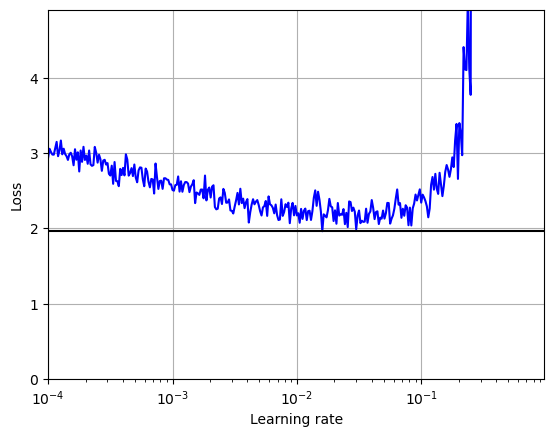

In [28]:

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [29]:
# OneCycleScheduler 自定义回调会在每个批次开始时更新学习率。
# 在训练的大约一半时间内线性增加学习率，然后线性降低回初始学习率。
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

In [30]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [31]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2889 - loss: 2.0562 - val_accuracy: 0.3630 - val_loss: 1.8063
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3776 - loss: 1.7619 - val_accuracy: 0.4172 - val_loss: 1.6774
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4244 - loss: 1.6237 - val_accuracy: 0.4206 - val_loss: 1.6804
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4514 - loss: 1.5468 - val_accuracy: 0.4294 - val_loss: 1.6983
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4739 - loss: 1.4906 - val_accuracy: 0.4462 - val_loss: 1.6886
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4894 - loss: 1.4449 - val_accuracy: 0.4662 - val_loss: 1.6419
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5049 - loss: 1.4063 - val_accuracy: 0.4716 - val_loss: 1.6118
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5262 - loss: 1.3333 - val_accuracy: 0.